# Semantic Segmentation using Attention Guided Chained Context Aggregation



1.   One of the main issues in semantic segmantation is to aggregate multiscale contextual information effectively. For this, a novel paradigm called Chained Context Agregation Module (CAM) has been proposed.CAM gains features of various
spatial scales through chain-connected ladder-style information flows. CAM captures features of various scales at different levels and aggregates them in stages
by the chain-connected ladder-style information flows.
2.   Semantic segmentation is a vital task in computer vision used to assign currosponding semantic labels to individual pixels in images and has applications in automatic driving, medical imaging etc.
3. FCN's gain increasing receptive feild and high level contexts - through cascaded convolution and pooling layers. However, continuous downsampling process causes loss of spatial details, resulting in poor object delination.



In [ ]:
# unzip tar file with original images
import tarfile
fname = 'idd-segmentation.tar.gz'
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()

#### Import libraries

In [4]:
import cv2
import matplotlib.pyplot as plt
from scipy.misc.pilutil import imread

In [ ]:
import shutil
import os
import numpy as np
import json
import pandas as pd
import pprint
import tensorflow as tf
import time
from tensorflow import keras
from keras.layers import *
from keras.preprocessing import image

from glob import glob
import sys
import random

#matplotlib.use('agg')
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from PIL import Image

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [ ]:
# set maximum output limit of an ipython cell
%%javascript
IPython.OutputArea.auto_scroll_threshold = 50;

In [ ]:
#new_datasetPath = 'Anue_dataset/'
fine_labels_ = 'gtFine' # Folder with annotated images
leftImgsDir = 'leftImg8bit'# Folder with Png images
modes = ['train','val']  # folders with images
#data_dirs = ['Dataset','Dataset_2','Dataset_3','Dataset_4','Dataset_5','Dataset_6','Dataset_7','Dataset_8']
data_dirs = ['IDD_Segmentation'] #main folder 
tmpAll_dir = 'Anue_dataset/tmpAll' # temperoary directory to store images
#os.mkdir(tmpAll_dir) #Added




img_anno_arr = [] #array for annotated images, contains only numbers eg:571043','148237','243905','300132'


for data_dir in data_dirs: # for data in IDD_Segmentation ~ ['gtfine','leftIng8bit']
    fine_label_path = os.path.join(data_dir,fine_labels_) # IDD_Segmentation/gtFine
    leftImgPath = os.path.join(data_dir,leftImgsDir) #IDD_Segmentation/LeftImg8bit
    
    for mode in modes: # for mode in train/val
        fine_label_path_mode = os.path.join(fine_label_path,mode) # IDD_Segmentation/gtFine/mode (train/val)
        leftImgPath_mode = os.path.join(leftImgPath,mode) # IDD_Segmentation/leftImg8bit/mode (train/val)
        all_labels_dir = sorted(os.listdir(fine_label_path_mode)) #Sort all the files in fine_labels path mode
        all_imgs_dir = sorted(os.listdir(leftImgPath_mode))#Sort all the files in left_img_path_mode so that both the folders
                                                            # have the same order of images and annotated images
        common_dirs = sorted(list(set(all_labels_dir).intersection(all_imgs_dir)))#Make sure the directory is available in both 
        #gtFine and leftImgval and store it in common_dirs. If an extra directory is  there, we will not consider it
        # Directories in common_dirs are ['0','1','10','100'......]
        
        
        for com_dir in common_dirs: # take each folder like 0, then 1...
            all_fine_labels_path = os.path.join(fine_label_path_mode,com_dir)
            #all_fine_labels_path = IDD_Segmentation/gtFine/train/0
            all_imgs_path = os.path.join(leftImgPath_mode,com_dir)
            #all_imgs_path = IDD_Segmentation/leftImg8bit/train/0
            #print()
            print(com_dir)
            annots = os.listdir(all_fine_labels_path)###annots = IDD_Segemntation/gtfine/train/0/files....(If  present in images also)
            imgss = os.listdir(all_imgs_path)#####imgss = IDD_Segmentation/Img8bit/train/0/files......
            
            img_arr = [img_name[:img_name.find('_')] for img_name in imgss] 
            # IDD_Segmentation/Img8bit/train/0/005506_leftImg8bit.png is stored as 005506 in the array img_arr
            
            
            for anno in annots:
                if anno[:anno.find('_')] in img_arr: # if same annotation number is present in img_arr, them proceed
                    img_anno_arr.append(anno[:anno.find('_')]) #apend the annotated image number in array
        
                    whole_anno_path = os.path.join(all_fine_labels_path,anno)# IDD_Segmentation/Img8bit/train/0/005506_gtFine.json
                    print(whole_anno_path)
                    whole_img_name = str(anno[:anno.find('_')])+str('_leftImg8bit.png') # annotation image nmber_leftImg8bit.png
                    whole_img_path = os.path.join(all_imgs_path,whole_img_name) # IDD_Segmentation/leftImg8bit/train/0/nmber_leftImg8bit.png
                    print(whole_img_path)
                    shutil.copy(whole_anno_path,tmpAll_dir) # copy the annotated images to tempall.dir
                    shutil.copy(whole_img_path,tmpAll_dir)# copy the images to tempall.dir
                    


In [ ]:
p = sorted(os.listdir(tmpAll_dir)) #sort all images and gtfine to make them next to each other
# eg : '000035_gtFine_polygons.json', '000035_leftImg8bit.png'........
print(p)


In [ ]:
pk = [int(name[:name.find('_')]) for name in p]
pk = np.unique(pk) # store only unique numbers in the array
# '000035_gtFine_polygons.json', '000035_leftImg8bit.png' will be stored as 000035

In [ ]:
kk = sorted(np.unique(np.array(img_anno_arr).astype(int)))
pk[pk==kk]=1
sum(pk)# number of files in the array

In [ ]:
new_modes = ['train','val','test']
np.random.shuffle(img_anno_arr)# shuffle annotation beginning numbers randomly
test_split_idx = int(0.8*len(img_anno_arr)) #get 0.8*len of image anno array
trainval_elemts = img_anno_arr[:test_split_idx] # get top 80% numbers, we will use them as train and val, rest is test
test_elemts = img_anno_arr[test_split_idx:]# the last 20% are test numbers
val_split_idx = int(0.8*len(trainval_elemts))# 0.8*0.8*total array ~ 0.64 of total array
train_elemts = trainval_elemts[:val_split_idx] #top 0.64 of trainval split is train elements
val_elemts = trainval_elemts[val_split_idx:]# the rest are validation elements
#print(len(train_elemts),len(val_elemts),len(test_elemts))

In [ ]:
new_datasetPath = 'new_dataset'

#Moving files seperated into train, val, test - in a different folder called new_dataset
dset = [train_elemts,val_elemts,test_elemts]
for idx,mode in enumerate(new_modes):# 0,train; 1,val; 2,test 
    new_fine_label_path = os.path.join(new_datasetPath,fine_labels_,mode)
    new_leftImg_path = os.path.join(new_datasetPath,leftImgsDir,mode)
    #move the files to a different folder
    for elemt in dset[idx]:
        new_label = str(elemt)+str('_gtFine_polygons.json')
        new_img = str(elemt)+str('_leftImg8bit.png')
        new_lab_path = os.path.join(new_fine_label_path,new_label)
        new_img_path = os.path.join(new_leftImg_path,new_img)
        
        shutil.copy(os.path.join(tmpAll_dir,new_label),new_lab_path)
        shutil.copy(os.path.join(tmpAll_dir, new_img), new_leftImg_path)

# Generate Segmentation images

In [ ]:
with open('label_to_color_map.txt') as f:
    label_to_color_map = json.load(f)
#label_to_color_map has the label with a color in rgb format:
#"tunnel": [150,120, 90], "non-drivable fallback": [156, 60, 200], "motorcycle": [0,0,230],......

label_arr = np.arange(len(label_to_color_map.keys()))
color_arr = label_to_color_map.values()

id_to_label_map = {}
label_to_id_map = {}
color_to_id_map = {}
for i,class_id in enumerate(label_arr):
    label = list(label_to_color_map.keys())[i]
    color = list(label_to_color_map.values())[i]
    id_to_label_map[str(class_id)] = label
    label_to_id_map[label] = str(class_id)
    #color_to_id_map[color] = str(class_id)
#Id_To_label_map has an id for every label eg: "0": "tunnel", "1": "non-drivable fallback", "2": "motorcycle", 
#label_to_id_map is the opposite of Id_to_label_map

In [ ]:

#write them to text files and save
with open('class_id_to_label_map.txt', 'w+') as ff:
    ff.write(json.dumps(id_to_label_map))

    
with open('label_to_id_map.txt','w+') as fff:
    fff.write(json.dumps(label_to_id_map))


#### Fill the polygons with the respective color

In [ ]:
prev_data_path = 'new_dataset'
new_data_path = 'labelled_Anue_dataset'
lab_path = 'gtFine'
im_path = 'leftImg8bit'                     #(This folder was copied to new_data_path as it is)
modes = ['train','test','val'] 

#### Generate class_id to label map
#### Make ground truth images coloured as per annotations and color mapping defined
#need to update gtFine in new data path by replacing json files from old dataset and extracting polygons and
#colorising the images. Then we will assign class_ids to pixel locations according to segmented class and 
# generate a map of HxWx1 size where H,W are height and width of images, thereby assigning each pixel(set of rgb)
# 1 class_id which corresponds to a particular class


for mode in modes:
    old_imgs_path = os.path.join(prev_data_path,im_path,mode) #### path where the images are stored in train/val/test data
    ###new_dataset/leftImg8bit/train/.....
    old_anno_path = os.path.join(prev_data_path,lab_path,mode)
    ####### path where annotated images are stored
    #new_dataset/GTFine/train/
    imgs = os.listdir(old_imgs_path) ### making a directory to images path
    for img_ in imgs:
        anno_file_name = str(img_[:img_.find('_')])+str('_gtFine_polygons.json')
        # get annotated file 000030_leftImg8bit.png replaced as 000030__gtFine_polygons.json
        anno_file = os.path.join(old_anno_path,anno_file_name)
        # created a path to annotated file  000030__gtFine_polygons.json
        with open(anno_file) as ff:
            #open  000030__gtFine_polygons.json
            data = json.load(ff)
            
            #load contents of 000030__gtFine_polygons.json into data
            cur_img = cv2.imread(os.path.join(old_imgs_path,img_),cv2.IMREAD_UNCHANGED)
            #Read the following image in cur_img 000030_leftImg8bit.json
            for i, obj in enumerate(data['objects']):
                obj_label = obj['label']
                # sky,wall,road.....
                #try:
                color_tuple = tuple(label_to_color_map[obj_label])
                #except KeyError:
                    #pass
                cv2.fillPoly(cur_img,[np.array(obj['polygon']).astype(np.int32)],color=color_tuple)
                #fill the polygon coordinates with the respective color
            save_path_img = os.path.join(new_data_path,im_path,mode,img_)
            cv2.imwrite(save_path_img, cur_img)
            

# Get paths of images and currosponding segmentation images

In [2]:
image_paths_train = glob('IDD_Canet/new_dataset/leftImg8bit/train/*_leftImg8bit.png')
#D:\APPLIEDAI\Mayank\labelled_Anue_dataset\leftImg8bit\train
#D:\APPLIEDAI\Mayank\new_dataset\leftImg8bit\train
label_paths_train = [p.replace('new_dataset', 'labelled_Anue_dataset') for p in image_paths_train]

In [3]:
image_paths_train[1:5]

['IDD_Canet/new_dataset/leftImg8bit/train\\000128_leftImg8bit.png',
 'IDD_Canet/new_dataset/leftImg8bit/train\\000263_leftImg8bit.png',
 'IDD_Canet/new_dataset/leftImg8bit/train\\000282_leftImg8bit.png',
 'IDD_Canet/new_dataset/leftImg8bit/train\\000290_leftImg8bit.png']

In [4]:
label_paths_train[1:5]

['IDD_Canet/labelled_Anue_dataset/leftImg8bit/train\\000128_leftImg8bit.png',
 'IDD_Canet/labelled_Anue_dataset/leftImg8bit/train\\000263_leftImg8bit.png',
 'IDD_Canet/labelled_Anue_dataset/leftImg8bit/train\\000282_leftImg8bit.png',
 'IDD_Canet/labelled_Anue_dataset/leftImg8bit/train\\000290_leftImg8bit.png']

In [5]:
#val images
image_paths_val = glob('IDD_Canet/new_dataset/leftImg8bit/val/*_leftImg8bit.png')
label_paths_val = [p.replace('new_dataset', 'labelled_Anue_dataset') for p in image_paths_val]


In [6]:
image_paths_test = glob('IDD_Canet/new_dataset/leftImg8bit/test/*_leftImg8bit.png')
label_paths_test = [p.replace('new_dataset', 'labelled_Anue_dataset') for p in image_paths_test]

In [97]:
print("length of train images:" ,len(label_paths_train))
print("length of train segmentation images:", len(image_paths_train))
print("length of test images:" ,len(image_paths_test))
print("length of test segmentation images:" ,len(label_paths_test))
print("length of Val images:" ,len(image_paths_val))
print("length of Val segmentation images:" ,len(label_paths_val))

length of train images: 5058
length of train segmentation images: 5058
length of test images: 1592
length of test segmentation images: 1592
length of Val images: 1271
length of Val segmentation images: 1271


#### Below is an example of an image and the respective segmentation image

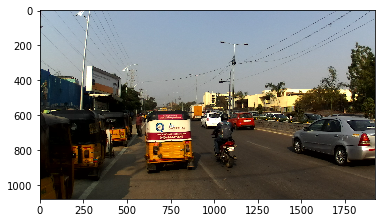

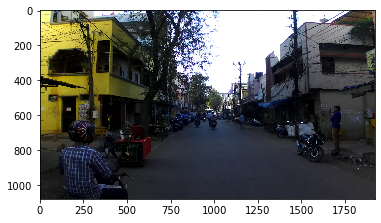

In [99]:
%matplotlib inline
for i in range(2):
    #print(image_paths[i], label_paths[i])
    
    image_frame =imread(image_paths_train[i])
    
    #get the label images that have the map values encoded in them
   
    plt.imshow(image_frame)
    plt.show()

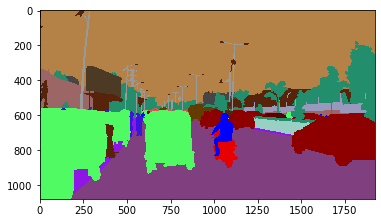

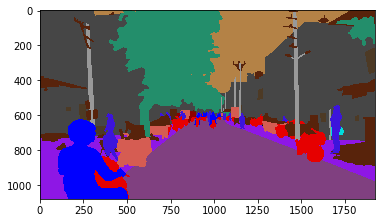

In [100]:
%matplotlib inline
for i in range(2):
    #print(image_paths[i], label_paths[i])
    
    image_frame =imread(label_paths_train[i])
    
    #get the label images that have the map values encoded in them
   
    plt.imshow(image_frame)
    plt.show()

#### Colours of all 39 classes shown beow

In [ ]:
colors = np.array([
    [150, 120, 90],  #'tunnel': 
    [156, 60, 200],  #'non-drivable fallback':
    [0, 0, 230],#'motorcycle':
    [150, 100, 100],#'bridge': 
    [250, 170, 160],#'parking':
    [244, 35, 232],#'sidewalk':
    [199, 151, 187],#'animal':
    [107, 142, 35],#'vegetation': 
    [128, 64, 128],#'road':
    [220, 20, 60],#'person':
    [37, 58, 77],#'billboard':
    [225, 130, 123],#'fallback background':
    [70, 130, 180],#'sky': 
    [196, 209, 152],#'curb':
    [70, 70, 70],#'building':
    [153, 153, 153],#'polegroup': 
    [99, 250, 80],#'autorickshaw':
    [250, 170, 30],#'traffic light': 
    [255, 0, 0],#'rider':
    [82, 92, 214],# 'vehicle fallback':
    [220, 220, 0],#'traffic sign': 
    [0, 0, 0],# 'out of roi':
    [119, 11, 32],#'bicycle':
    [0, 60, 100],#'bus':
    [11, 35, 88],#'obs-str-bar-fallback':
    [102, 102, 156],#'wall': 
    [0, 0, 90],# 'caravan': 
    [153, 153, 153],#'pole':
    [190, 153, 153],#'fence':
    [229, 23, 142],#'drivable fallback':
    [180, 165, 180],#'guard rail':
    [0, 0, 142],#'car':
    [0, 0, 70],#'truck': 
    [32, 64, 128],# 'license plate':
    [192, 192, 192],#'rail track':
    [89, 202, 34],#'rectification border': 
    [10, 100, 200],#'ego vehicle': 
    [50, 150, 250],#'trailer':
    [35, 105, 70] # train
], dtype=np.int)

In [72]:
#image dimensons need to be a multiple of 32
input_height, input_width = 128, 128
output_height, output_width = 128, 128
n_classes = 39

X_train, y_train = [],[]
X_val, y_val =  [],[]
X_test,y_test = [],[]


In [55]:
#get the image array
def getImageArr(path, width, height):
  img = cv2.imread(path, 1)
  img = np.float32(cv2.resize(img, (width, height)))/127.5 - 1 #np.float32/uint8
  return img

'def getSegmentationArr(path, nClasses, width, height): \n  seg_labels = np.zeros((height, width, nClasses))\n  img = cv2.imread(path, 1)\n  img = cv2.resize(img, (width, height))\n  img = img[:, :, 0]\n\n  for c in range(nClasses):\n    seg_labels[:, :, c] = (img == c).astype(int)\n\n  return seg_labels'

In [56]:

with open('label_to_color_map.txt') as f:
    label_to_color_map = json.load(f)
    
#label_to_Color_map
#tunnel - (150,120,90)..etc

In [58]:
label_arr = np.arange(len(label_to_color_map.keys()))
color_arr = label_to_color_map.values()

In [59]:
id_to_label_map = {}
label_to_id_map = {}
color_to_id_map = {}
for i,class_id in enumerate(label_arr):
    label = list(label_to_color_map.keys())[i]
    color = list(label_to_color_map.values())[i]
    id_to_label_map[str(class_id)] = label
    label_to_id_map[label] = str(class_id)
    #color_to_id_map[color] = str(class_id)

In [82]:
#id_to_label_map
#0:tunnel
#1:non-drivble motorcycle

In [73]:
#get the segmentation array
def getSegmentationArr(path, nClasses, width, height): 
  seg_labels = np.zeros((height, width, nClasses))
  img = cv2.imread(path, 1)
  img = cv2.resize(img, (width, height))
  #img = img[:, :, 0]

  for key in list(label_to_color_map.keys()):
        #whereever the image is equal to the colors from the label_to_color_map
        #fill all the 3 layers with the respective class ID
        cur_color = np.array(label_to_color_map[key])[:3]
        img[np.where((img==cur_color).all(axis=2))] = int(label_to_id_map[key])
  #Take only one layer because we are only concerned with the ID      
  img = img[:, :, 0]
  #return the image in array form  
  for c in range(nClasses):
    seg_labels[:, :, c] = (img == c).astype(int)

  return seg_labels

#### Read the train, Val and test images 

In [74]:
from tqdm import tqdm
for i in tqdm(range(len(image_paths_train))):
  X_train.append(getImageArr(image_paths_train[i], input_width, input_height))
  y_train.append(getSegmentationArr(label_paths_train[i], n_classes, output_width, output_height))

100%|██████████████████████████████████████████████████████████████████████████████| 5058/5058 [06:53<00:00, 12.24it/s]


In [76]:
X_train, y_train = np.array(X_train), np.array(y_train, dtype=np.uint8)
print(X_train.shape,y_train.shape)

(5058, 128, 128, 3) (5058, 128, 128, 39)


In [77]:
from tqdm import tqdm
for i in tqdm(range(len(image_paths_val))):
  X_val.append(getImageArr(image_paths_val[i], input_width, input_height))
  y_val.append(getSegmentationArr(label_paths_val[i], n_classes, output_width, output_height))

100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [02:13<00:00,  9.55it/s]


In [78]:
X_val, y_val = np.array(X_val),np.array(y_val,dtype=np.uint8)
print(X_val.shape, y_val.shape)

(1271, 128, 128, 3) (1271, 128, 128, 39)


In [35]:
from tqdm import tqdm
for i in tqdm(range(len(image_paths_test))):
  X_test.append(getImageArr(image_paths_test[i], input_width, input_height))
  y_test.append(getSegmentationArr(label_paths_test[i], n_classes, output_width, output_height))

100%|██████████████████████████████████████████████████████████████████████████████| 1592/1592 [02:00<00:00, 13.18it/s]


In [36]:
X_test, y_test = np.array(X_test),np.array(y_test,dtype=np.uint8)
print(X_test.shape, y_test.shape)

(1592, 128, 128, 3) (1592, 128, 128, 39)


## MODEL ARCHITECTURE



1.   Global Flow (GF) makes use of the shared features encoded
by the backbone network to obtain global receptive field,
which is advantageous to establish a perception of the entire image scene and reduce mislabeled pixels of similar objects.
2.   Context Flow (CF) consists
of two parts: the shared features and the output features of
upper flow. Stacked convolutional and pooling layers with
various strides are adopted within CFs to exploit local contexts of individual scales. Context Flows (CFs) are to exploit local contexts of different receptive field.  Receptive filed is nothing but the region in the input volume that a particular feature extractor (filter) is looking at. This is also sometimes called as the context.
To put in very simple terms, receptive field (context) is the area of the input image that the filter covers at any given point of time.


*   Context Fusion Module is used
(CFM) to fuse them effectively. More specifically, given the
two inputs of different spatial scales, CFM firstly concats
them in the channel dimension and downsampling N times
through an average pooling layer that also lessens computation cost. The following two consecutive convolutional layers can eliminate the aliasing effect and further enlarge the
receptive field, where group convolutions and channel shuffle are adopted to diminish model parameters. 
*   Then the
spatial-attention based Context Refinement Module (CRM)
refines the fused features.


3.   A simple decoder is manipulated to restore fine spatial
details during upsampling in the end.

References: 

Resnet- architecture: https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb

PAPER: https://arxiv.org/pdf/2002.12041.pdf

<img src = Architecture.png>
<img src = arch_2.png>
<img src = arch_3.png>

In [39]:
#https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [42]:
#https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [19]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [20]:
def convolutional_block(X, f, filters, stage, block, s = 1):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [21]:
X_input = Input((128,128,3))

    # Zero-Padding
    #X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
X = Conv2D(64, (3, 3), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
X_ag_cat = convolutional_block(X, f=3, filters=[4, 4, 8], stage=2, block='a', s=4)
X = identity_block(X_ag_cat, 3, [4, 4, 8], stage=2, block='b')
X = identity_block(X, 3, [4, 4, 8], stage=2, block='c')

    # Stage 3 (≈4 lines)
X = convolutional_block(X, f = 3, filters = [8, 8, 16], stage = 3, block='a', s = 1)
X = identity_block(X, 3, [8, 8, 16], stage=3, block='b')
X = identity_block(X, 3, [8, 8, 16], stage=3, block='c')
X = identity_block(X, 3, [8, 8, 16], stage=3, block='d')

    # Stage 4 (≈6 lines)
X = convolutional_block(X, f = 3, filters = [16, 16, 32], stage = 4, block='a', s = 1)
X = identity_block(X, 3, [16, 16, 32], stage=4, block='b')
X = identity_block(X, 3, [16, 16, 32], stage=4, block='c')
X = identity_block(X, 3, [16, 16, 32], stage=4, block='d')
X = identity_block(X, 3, [16, 16, 32], stage=4, block='e')
X = identity_block(X, 3, [16, 16, 32], stage=4, block='f')

    # Stage 5 (≈3 lines)
X = convolutional_block(X, f = 3, filters = [32, 32, 64], stage = 5, block='a', s = 1)
X = identity_block(X, 3, [32, 32, 64], stage=5, block='b')
X = identity_block(X, 3, [32, 32, 64], stage=5, block='c')

x_GF = AveragePooling2D(1,(16,16))(X)                       #Global Average pooling changes the dimensions of the output. Instead use average   
x_GF2 = BatchNormalization()(x_GF)                               # pooling with the kernal dimensions equal to that of the entire layer
x_GF3 = Activation('relu')(x_GF2)    
GF_Conv_1 = Conv2D(32, (1, 1), activation = 'relu', padding = 'same', name = 'GF_conv1' )(x_GF3)
GF_Conv_T = (Conv2DTranspose(32 ,(16,16), use_bias = False))(GF_Conv_1)


c1 = Concatenate()([X,GF_Conv_T])
CF_x1 = AveragePooling2D((2, 2),  (2, 2), name = 'CF1_pool' )(c1)
CF_Conv_11 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', name = 'CF1_conv1' )(CF_x1)
CF_Conv_12 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', name = 'CF1_conv2')(CF_Conv_11)
CF_Conv_13 = Conv2D(32, (1, 1), activation = 'relu', padding = 'same', name = 'CF1_conv3' )(CF_Conv_12)
CF_x2 = Activation('relu')(CF_Conv_13)
CF_Conv_14 = Conv2D(32, (1, 1), activation = 'relu', padding = 'same', name = 'CF1-conv4' )(CF_x2)
CF_x3 = Activation('sigmoid')(CF_Conv_14)
CF_x4 = Multiply()([CF_Conv_12 , CF_Conv_14])
CF_x5 = Add()([CF_Conv_12,CF_x4])
CF_Conv_T1 = (Conv2DTranspose(32 ,  (9, 9), use_bias = False ))(CF_x5) 


c12= concatenate([X,CF_Conv_T1])
x = AveragePooling2D((2, 2), (2, 2), name = 'CF2_pool' )(c12)
CF_Conv_21 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', name = 'CF2_conv1' )(x)
CF_Conv_22 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', name = 'CF2_conv2' )(CF_Conv_11)
CF_Conv_23 = Conv2D(32, (1, 1), activation = 'relu', padding = 'same', name = 'CF2_conv3')(CF_Conv_12)
x = Activation('relu')(CF_Conv_13)
CF_Conv_24 = Conv2D(32, (1, 1), activation = 'relu', padding = 'same', name = 'CF2_conv4' )(x)
x =  Activation('sigmoid')(CF_Conv_24)
x = Multiply()([CF_Conv_22 , CF_Conv_24])
x = Add()([CF_Conv_22,x])
CF_Conv_T2 = (Conv2DTranspose(32 , (9, 9), use_bias = False ))(x)


c3 = concatenate([X,CF_Conv_T2])
x = AveragePooling2D((2, 2),  (2, 2), name = 'CF3_pool')(c1)
CF_Conv_31 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', name = 'CF3_conv1')(x)
CF_Conv_32 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', name = 'CF3_conv2')(CF_Conv_11)
CF_Conv_33 = Conv2D(32, (1, 1), activation = 'relu', padding = 'same', name = 'CF3_conv3' )(CF_Conv_12)
x = Activation('relu')(CF_Conv_13)
CF_Conv_34 = Conv2D(32, (1, 1), activation = 'relu', padding = 'same', name = 'CF3_conv4' )(x)
x = Activation('sigmoid')(CF_Conv_34)
x =  Multiply()([CF_Conv_32 , CF_Conv_34])
x = Add()([CF_Conv_32,x])
CF_Conv_T3 = (Conv2DTranspose(32 ,  (9, 9), use_bias = False ))(x)


o = Add(name = 'add')([GF_Conv_T, CF_Conv_T1, CF_Conv_T2, CF_Conv_T3])

FS_Conv_1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', name = 'FS_conv1')(o)
x = AveragePooling2D(1,(2, 2), name = 'FS_pool')(FS_Conv_1)
FS_Conv_2 = Conv2D(32, (1, 1), activation = 'relu', padding = 'same', name = 'FS_conv2')(x)
bn = BatchNormalization()(FS_Conv_2)
s = Activation('sigmoid')(bn)
FS_Conv_T = Conv2DTranspose(32 ,  (9, 9), use_bias = False )(s)
x = Multiply()([FS_Conv_1,FS_Conv_T])


mid_Conv = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', name = 'FS_Conv3')(x)


AG_Conv_L1 = Conv2D(32, (7, 1), activation = 'relu', padding = 'same', name = 'AG_conv1' )(X_ag_cat)
AG_Conv_L2 = Conv2D(32, (1, 7), activation = 'relu', padding = 'same', name = 'AG_conv2')(AG_Conv_L1)

AG_Conv_R1 = Conv2D(32, (1, 7), activation = 'relu', padding = 'same', name = 'AG_conv3' )(X_ag_cat)
AG_Conv_R2 = Conv2D(32, (7, 1), activation = 'relu', padding = 'same', name = 'AG_conv4')(AG_Conv_R1)

o2 = Add()([AG_Conv_L2,AG_Conv_R2])

AG_Conv_F1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', name = 'AG_conv5' )(o2)

o3 = Add()([o2,AG_Conv_F1])


Conc_A =  (UpSampling2D((2,2), interpolation='bilinear'))(mid_Conv) #(Conv2DTranspose(nClasses , (113,113), use_bias = False ))(mid_Conv)
Conc_B = (UpSampling2D((2,2), interpolation='bilinear'))(o3)
CF = concatenate([Conc_A,Conc_B])
Final = Conv2D(39, (3, 3), activation = 'relu', padding = 'same', name = 'FinalBlock1')(CF)
    
o_Final  = UpSampling2D((4,4), interpolation = 'bilinear')(Final)
Final = (Activation('softmax'))(o_Final)
model = Model(inputs = X_input, outputs = Final, name='ResNet50')

model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 126, 126, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 126, 126, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 126, 126, 64) 0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [79]:
import datetime
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
rms = optimizers.RMSprop()
model.compile(loss = 'categorical_crossentropy', optimizer = rms, metrics = [iou_coef,dice_coef,'accuracy'])
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
#stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
mcp_save = ModelCheckpoint('weights-improvement.rescan_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, verbose=1, min_delta=1e-4, mode='min')

#### Train the model

In [81]:
hist1 = model.fit(X_train, y_train, validation_data = (X_val, y_val),batch_size = 16, epochs = 70, verbose = 1,callbacks = [tensorboard_callback,mcp_save,reduce_lr_loss])

Train on 5058 samples, validate on 1271 samples
Epoch 1/70
5058/5058 [==============================] - 715s 141ms/step - loss: 2.2510 - iou_coef: 0.1999 - dice_coef: 0.3269 - accuracy: 0.4290 - val_loss: 2.2806 - val_iou_coef: 0.1776 - val_dice_coef: 0.2967 - val_accuracy: 0.4262
Epoch 2/70
5058/5058 [==============================] - 702s 139ms/step - loss: 2.2206 - iou_coef: 0.2074 - dice_coef: 0.3370 - accuracy: 0.4369 - val_loss: 2.2325 - val_iou_coef: 0.1912 - val_dice_coef: 0.3153 - val_accuracy: 0.4428
Epoch 3/70
5058/5058 [==============================] - 696s 138ms/step - loss: 1.3913 - iou_coef: 0.3779 - dice_coef: 0.5368 - accuracy: 0.6442 - val_loss: 1.3354 - val_iou_coef: 0.4159 - val_dice_coef: 0.5765 - val_accuracy: 0.6588
Epoch 4/70
5058/5058 [==============================] - 695s 137ms/step - loss: 1.2994 - iou_coef: 0.4007 - dice_coef: 0.5615 - accuracy: 0.6650 - val_loss: 1.4913 - val_iou_coef: 0.3659 - val_dice_coef: 0.5274 - val_accuracy: 0.6023
Epoch 5/70
5058/

Epoch 35/70
5058/5058 [==============================] - 691s 137ms/step - loss: 1.0442 - iou_coef: 0.4891 - dice_coef: 0.6474 - accuracy: 0.7244 - val_loss: 1.1818 - val_iou_coef: 0.4569 - val_dice_coef: 0.6162 - val_accuracy: 0.6947
Epoch 36/70
5058/5058 [==============================] - 691s 137ms/step - loss: 1.0425 - iou_coef: 0.4891 - dice_coef: 0.6474 - accuracy: 0.7248 - val_loss: 1.1851 - val_iou_coef: 0.4628 - val_dice_coef: 0.6217 - val_accuracy: 0.6951

Epoch 00036: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 37/70
5058/5058 [==============================] - 690s 136ms/step - loss: 1.0419 - iou_coef: 0.4900 - dice_coef: 0.6483 - accuracy: 0.7251 - val_loss: 1.1820 - val_iou_coef: 0.4615 - val_dice_coef: 0.6205 - val_accuracy: 0.6954
Epoch 38/70
5058/5058 [==============================] - 692s 137ms/step - loss: 1.0416 - iou_coef: 0.4896 - dice_coef: 0.6479 - accuracy: 0.7251 - val_loss: 1.1819 - val_iou_coef: 0.4617 - val_dice_coef: 0.6206 - 

In [83]:
model.save("canetres50.h5")

#### Graphs for metrics

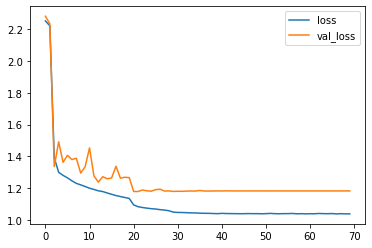

In [85]:
%matplotlib inline

for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key], label = key)
plt.legend()
plt.show()

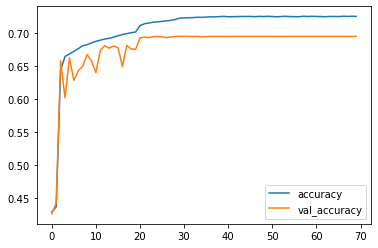

In [86]:
%matplotlib inline

for key in ['accuracy', 'val_accuracy']:
    plt.plot(hist1.history[key], label = key)
plt.legend()
plt.show()

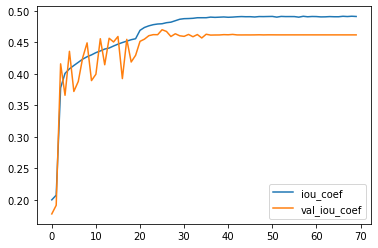

In [87]:
%matplotlib inline

for key in ['iou_coef', 'val_iou_coef']:
    plt.plot(hist1.history[key], label = key)
plt.legend()
plt.show()

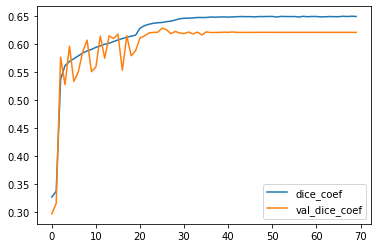

In [88]:
%matplotlib inline

for key in ['dice_coef', 'val_dice_coef']:
    plt.plot(hist1.history[key], label = key)
plt.legend()
plt.show()

- Full credit goes to the following repositories for extracting segmented images from normal ones.
 - https://github.com/AutoNUE/public-code 
 - https://github.com/divamgupta/image-segmentation-keras
 - https://github.com/acgeospatial/Automate_circular_field_mapping
 - https://github.com/anishmadan23/

## Summary

- The paper presents A NOVEL way for segmenting images. It builds up on the problem of aggregating multi-scale contextual information effectively to obtain reliable results, something that is faced in fully convolutional networks (FCN's).
- For this case study, due to space and memory constraints, I've used the IDD lite dataset. The dataset contains 1403 train images (normal and segmentation type each), 204 validation images(normal and segmentation type each) and around 400 test images (only normal each). At a future point, I will run the model on the entire dataset which contains over 6000 high defination images of 720p or 1080p (3000 normal and 3000 segmentation).
- I first get all the images and segmentation images in array format. The segmentation images contain 7 different classes for classification. 
- I developed the model architecture as explained in the paper and ran it for 70 but stopped at 53 epochs since the metrics stopped improving. 
- I got a final accuracy of Accuracy is 69.96%; Mean IoU as 46.84 and Dice Coefficient as 62.64 on my test dataset.
